In [2]:
# !pip install nflows

In [3]:
%reload_ext autoreload
%autoreload 2

import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [4]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, position, sampling_frequency,
 multiunits, multiunits_spikes) = make_simulated_run_data()

In [8]:
multiunits.shape

(350000, 4, 5)

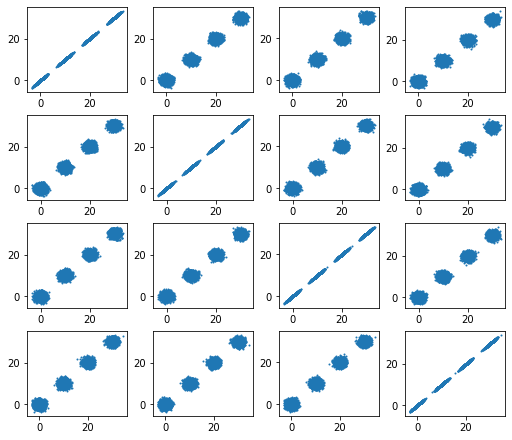

In [15]:
multiunit = multiunits[:, :, 0]
multiunit = multiunit[np.any(~np.isnan(multiunit), axis=1)]

fig, axes = plt.subplots(
    multiunit.shape[1],
    multiunit.shape[1],
    constrained_layout=True,
    figsize=(7, 6)
)

for ind1 in range(multiunit.shape[1]):
    for ind2 in range(multiunit.shape[1]):
        axes[ind1, ind2].scatter(multiunit[:, ind1], multiunit[:, ind2], s=1)

In [18]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet


def make_normalizing_flow_model(n_features=4):
    num_layers = 5
    base_dist = StandardNormal(shape=[n_features])

    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=n_features))
        transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, 
                                                              hidden_features=4))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    optimizer = optim.Adam(flow.parameters())
    
    return flow, optimizer


flow, optimizer = make_normalizing_flow_model()
num_iter = 5000
x = torch.tensor(multiunit, dtype=torch.float32)

for i in range(num_iter):
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()

In [19]:
flow.log_prob?

Signature: flow.log_prob(inputs, context=None)
Docstring:
Calculate log probability under the distribution.

Args:
    inputs: Tensor, input variables.
    context: Tensor or None, conditioning variables. If a Tensor, it must have the same
        number or rows as the inputs. If None, the context is ignored.

Returns:
    A Tensor of shape [input_size], the log probability of the inputs given the context.
File:      ~/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/nflows/distributions/base.py
Type:      method


In [ ]:
xline = torch.linspace(-1.5, 2.5, 100)
yline = torch.linspace(-.75, 1.25, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)